In [2]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-01 01:22:44.680061: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 01:22:44.689619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 01:22:44.700016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [4]:
data = Dataset('1d')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Fore

[Timestamp('2022-05-01 00:00:00'), Timestamp('2022-05-02 00:00:00'), Timestamp('2022-05-03 00:00:00'), Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-05 00:00:00'), Timestamp('2022-05-06 00:00:00'), Timestamp('2022-05-07 00:00:00'), Timestamp('2022-05-08 00:00:00'), Timestamp('2022-05-09 00:00:00'), Timestamp('2022-05-10 00:00:00'), Timestamp('2022-05-11 00:00:00'), Timestamp('2022-05-12 00:00:00'), Timestamp('2022-05-13 00:00:00'), Timestamp('2022-05-14 00:00:00'), Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-16 00:00:00'), Timestamp('2022-05-17 00:00:00'), Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-19 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('2022-05-21 00:00:00'), Timestamp('2022-05-22 00:00:00'), Timestamp('2022-05-23 00:00:00'), Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-25 00:00:00'), Timestamp('2022-05-26 00:00:00'), Timestamp('2022-05-27 00:00:00'), Timestamp('2022-05-28 00:00:00'), Timestamp('2022-05-29 00:00:00'), Timestamp('20

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mesBestframe = mesBestframe.groupby('Time Bin', sort=True).agg({'Περιγραφή υλικού':set,'Work Center':set,'Event Code':set,'Production Quantity (#)':sum,'Duration (min)':sum}).reset_index()
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:157: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  mesBestframe = mesBestframe.groupby('Time Bin', sort=True).agg({'Περιγραφή υ

KeyboardInterrupt: 

In [ ]:
data

NameError: name 'data' is not defined

In [ ]:
# data = Dataset('1h')
# data = data.preprocess()
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
# data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1   # Number of 15-min we want to look into the future based on the past (Out).
n_past = 2   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(seq, steps, out):
    X, Y = list(), list()
    for i in range(len(seq)):
        end = i + steps
        outi = end + out
        if outi > len(seq)-1:
            break
        seqx, seqy = seq[i:end, 1:], seq[end:outi, 0] # 1 the column number I want to make the prediction
        X.append(seqx)
        Y.append(seqy)
    return np.array(X), np.array(Y)

X_num, Y_num = split_sequence(numerical_data, n_past, n_future) # numerical sequences

# in order to align cat-num, I need to append the target feature to the categorical features
categorical_data.insert(0, 'Energy', numerical_data[:, 0].reshape(-1, 1)) #energy column scaled like the numerical process
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data)[1:], dtype=np.int64)
X_cat, Y_cat = split_sequence(categorical_data.to_numpy(), n_past, n_future) # categorical sequences
Y_cat = Y_cat.astype(np.float64)
X = np.concatenate((X_cat, X_num), axis=-1)

print(X_cat.shape, X_num.shape, Y_num.shape)


# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, Y_num, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp
print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)
del data, categorical_data, numerical_data

NameError: name 'data' is not defined

In [ ]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=1200, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.3, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.2, recurrent_dropout= 0.1)))
    model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-1-day(1d).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=2, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/30


I0000 00:00:1728239050.292385   82895 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728239050.318234   82895 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728239050.318360   82895 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728239050.319300   82895 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4639 - mae: 0.6502 - mape: 91.8234

I0000 00:00:1728239059.399067  121065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.4216 - mae: 0.6099 - mape: 86.2502
Epoch 1: val_loss improved from inf to 0.05438, saving model to ./models/model-1-day(1d).keras

Epoch 1: Learning rate is 9.999999747378752e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - loss: 0.4185 - mae: 0.6068 - mape: 85.8833 - val_loss: 0.0544 - val_mae: 0.1849 - val_mape: 57.8414
Epoch 2/30
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0694 - mae: 0.2044 - mape: 35.3176
Epoch 2: val_loss did not improve from 0.05438

Epoch 2: Learning rate is 9.999999747378752e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0712 - mae: 0.2080 - mape: 36.5656 - val_loss: 0.0600 - val_mae: 0.2050 - val_mape: 51.8259
Epoch 3/30
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0690 - mae: 0.2117 - mape: 35.7089
Epoch 3: val_loss did not improve from 0.05438

Epoch 3: Learning rate is 9.999999747378752e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0693 - mae: 0.2136 - mape: 36.6384 - val_loss: 0.0654 

In [ ]:
from keras.models import load_model
# load model

model = load_model('./models/model-1-day(1d).keras')
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


In [ ]:
predictions.shape

(7, 1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 33))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],33))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 5612.4850861875
Mean Squared Error (MSE): 47953031.3219248
Root Mean Squared Error (RMSE): 6924.812728292715
R² Score: -0.05892413923195572
Adjusted R² Score: -0.5883862088479335
Median Absolute Error: 4508.0799898544265
Mean Absolute Percentage Error (MAPE): 55.31315849760154 %


/tmp/ipykernel_82895/235520325.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_82895/235520325.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


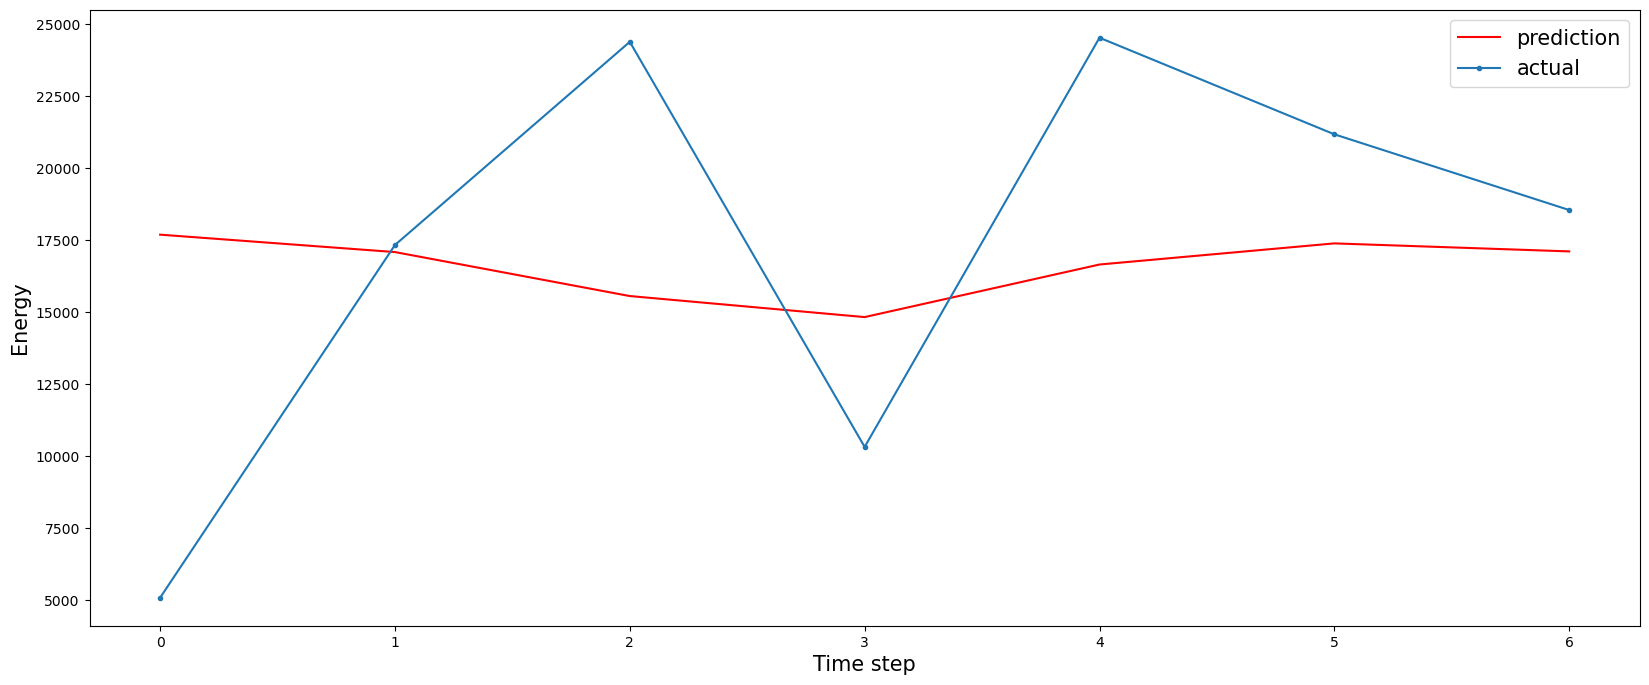

In [ ]:
pyplot.figure(figsize=(20,8))
pyplot.plot(predictions, label='prediction', color="r")
pyplot.plot(original, label='actual', marker='.')
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
# data = Dataset('4h')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [ ]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
# data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle= False)
print("Train sizes:")
print(X_train.shape,y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)


train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.0001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=30000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics


18497.151288043464
26225.97299999744
2030.295999996364
Train sizes:
(78, 196) (78,)
Validation sizes:
(7, 196) (7,)
Test sizes:
(7, 196) (7,)
[0]	train-rmse:0.97929	eval-rmse:1.12729
[100]	train-rmse:0.97054	eval-rmse:1.11832


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:26:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:0.96189	eval-rmse:1.10945
[300]	train-rmse:0.95332	eval-rmse:1.10067
[400]	train-rmse:0.94484	eval-rmse:1.09200
[500]	train-rmse:0.93644	eval-rmse:1.08342
[600]	train-rmse:0.92813	eval-rmse:1.07492
[700]	train-rmse:0.91990	eval-rmse:1.06652
[800]	train-rmse:0.91175	eval-rmse:1.05821
[900]	train-rmse:0.90369	eval-rmse:1.04999
[1000]	train-rmse:0.89571	eval-rmse:1.04185
[1100]	train-rmse:0.88781	eval-rmse:1.03380
[1200]	train-rmse:0.87999	eval-rmse:1.02584
[1300]	train-rmse:0.87225	eval-rmse:1.01796
[1400]	train-rmse:0.86458	eval-rmse:1.01017
[1500]	train-rmse:0.85700	eval-rmse:1.00246
[1600]	train-rmse:0.84950	eval-rmse:0.99484
[1700]	train-rmse:0.84208	eval-rmse:0.98729
[1800]	train-rmse:0.83473	eval-rmse:0.97981
[1900]	train-rmse:0.82745	eval-rmse:0.97238
[2000]	train-rmse:0.82025	eval-rmse:0.96503
[2100]	train-rmse:0.81312	eval-rmse:0.95776
[2200]	train-rmse:0.80607	eval-rmse:0.95056
[2300]	train-rmse:0.79909	eval-rmse:0.94345
[2400]	train-rmse:0.79217	eval-rmse:0.93

In [ ]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 37))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],37))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 3032.668852232581
Root Mean Squared Error (RMSE): 3435.8799161392485
Mean squared error (MSE): 11805270.798129048
R² Score: 0.7033667552364065
Adjusted R² Score: 1.0093673656241136


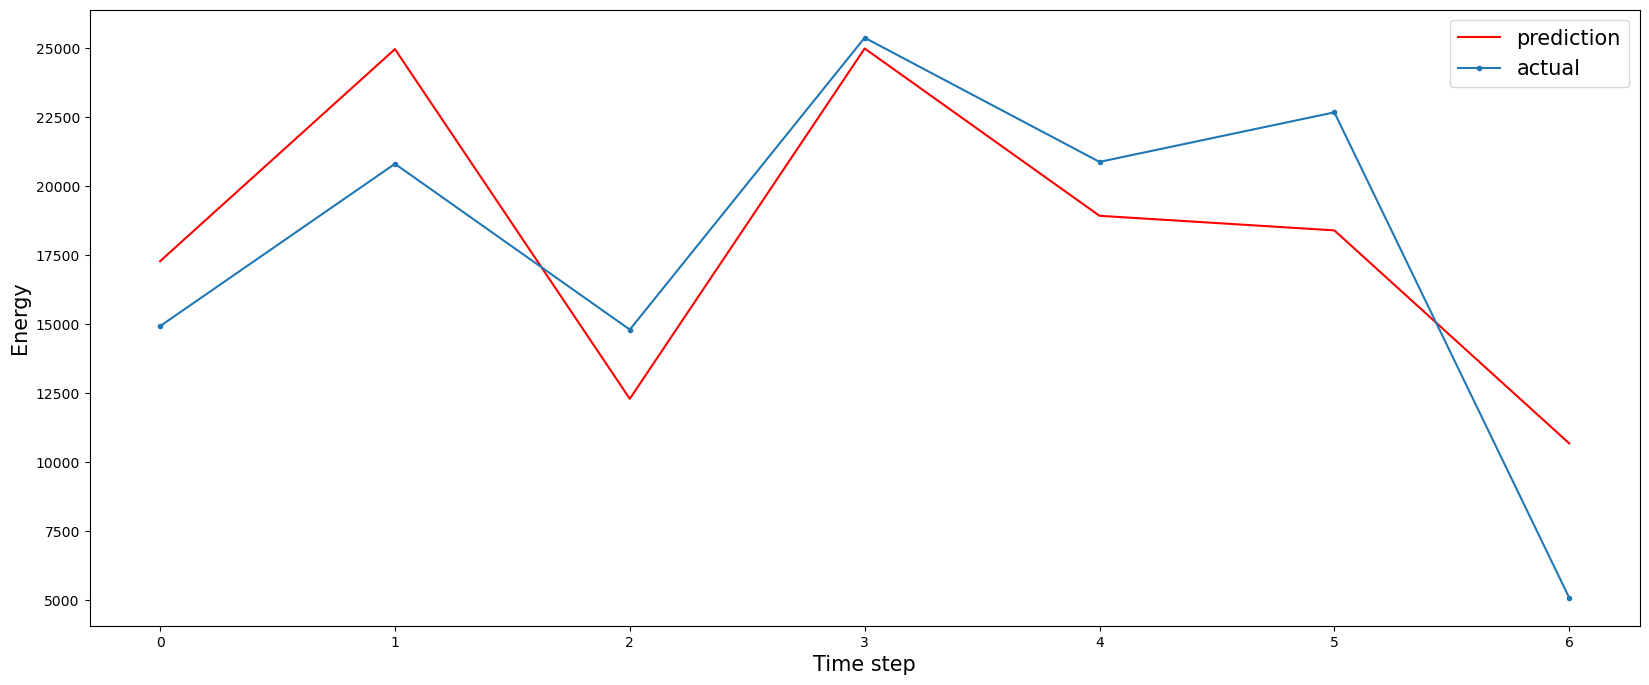

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

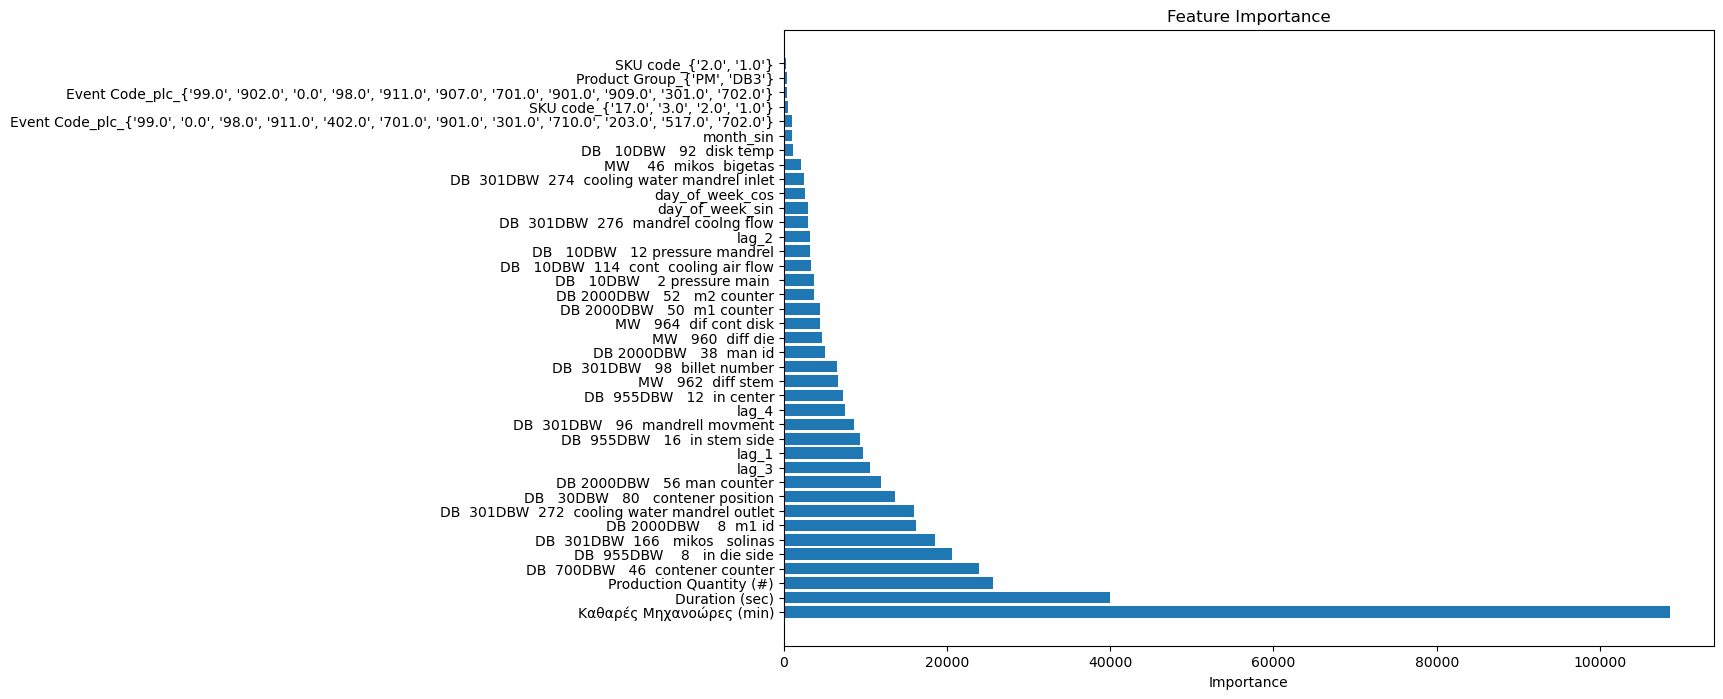

In [ ]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

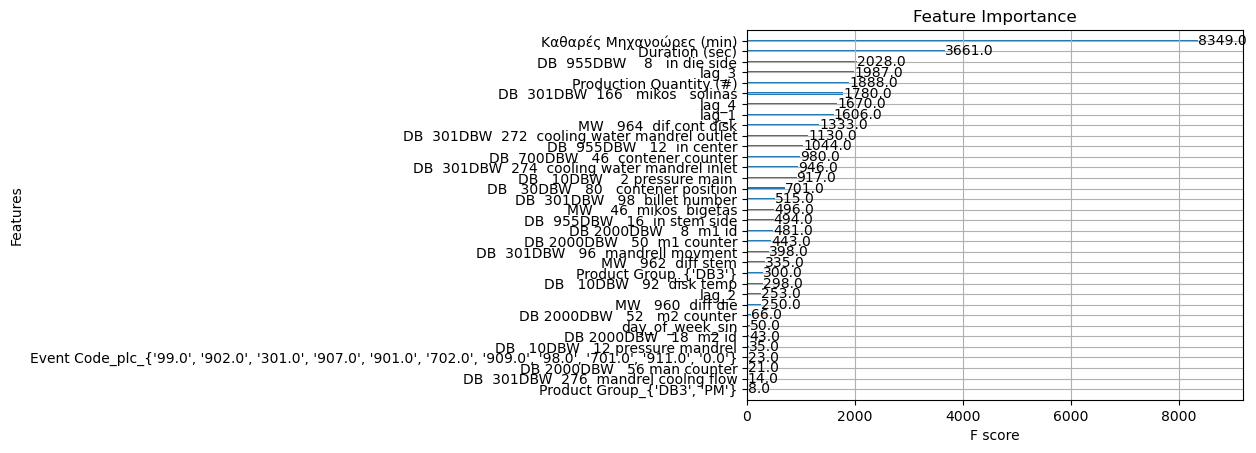

In [ ]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


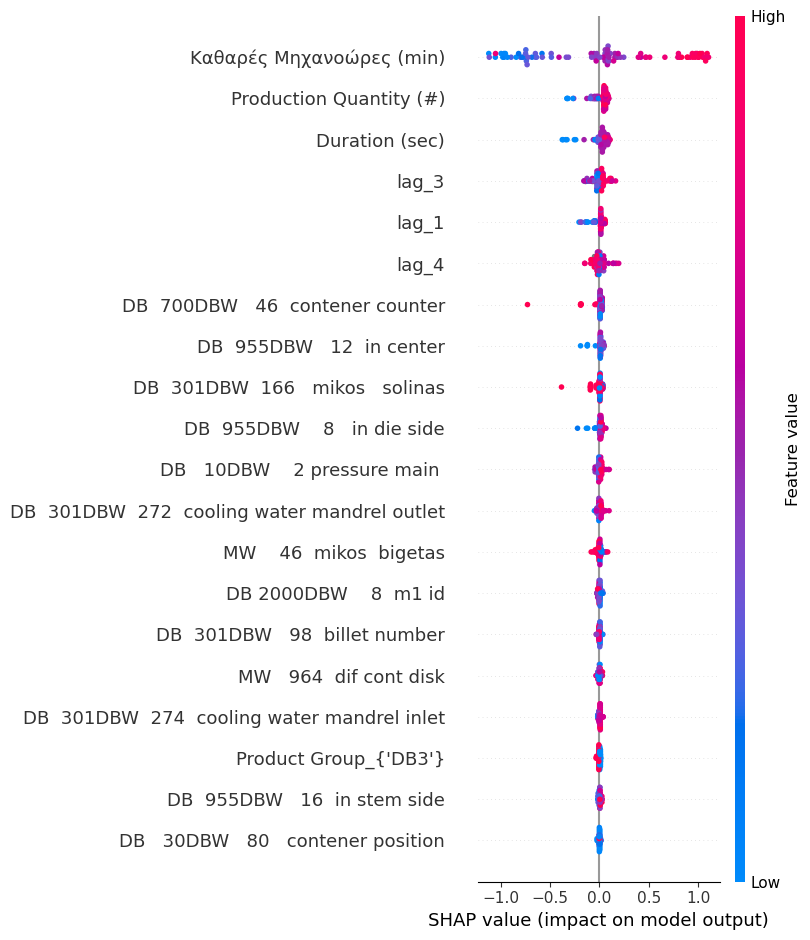

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)